In [2]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, processors
from tokenizers.normalizers import Sequence as NormalizerSequence, Lowercase, NFD, StripAccents
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers.decoders import BPEDecoder

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.nn.functional import one_hot
import torch.nn as nn
import torch.optim as optim

import gc
from collections import defaultdict
import random

import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/MyDrive/study/andan/dl_3_lab/'

Mounted at /content/drive


## Functions

In [4]:
class My_LSTM3(nn.Module):
    def __init__(self, features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim):
        super(My_LSTM3, self).__init__()
        self.embedding = nn.Embedding(features_vocab_total_words, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim[0], batch_first=True)
        self.lstm1 = nn.LSTM(hidden_dim[0], hidden_dim[1], batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim[1], hidden_dim[2], batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim[2], target_vocab_total_words)

    def forward(self, x):
        x = x.to(self.embedding.weight.device)
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out, _ = self.lstm1(lstm_out)
        lstm_out, _ = self.lstm2(lstm_out)
        lstm_out = self.dropout(lstm_out)
        output = self.fc(lstm_out[:, -1, :])
        return output

In [5]:
class Markov_Chain:
    def __init__(self):
        self.transition_counts = defaultdict(lambda: defaultdict(int))
        self.transition_probs = {}

    def fit(self, data):
        for row in data.itertuples(index=False):
            input_tokens = row[1:]
            target_token = row[0]

            last_token = input_tokens[-1]
            self.transition_counts[last_token][target_token] += 1

        for current_token, next_tokens in self.transition_counts.items():
            total = sum(next_tokens.values())
            self.transition_probs[current_token] = {
                token: count / total for token, count in next_tokens.items()
            }
            self.transition_probs[current_token] = dict(sorted(self.transition_probs[current_token].items(), key=lambda item: item[1], reverse=True))

    def generate_next_token(self, current_token, greedy=True):
        if current_token not in self.transition_probs:
            return random.choice(list(self.transition_probs.keys()))
        if not greedy:
            top_3_probs = dict(list(self.transition_probs[current_token].items())[:15])

            tokens = list(top_3_probs.keys())
            probs = list(top_3_probs.values())
            probs = np.array(probs) / np.sum(probs)
            return np.random.choice(tokens, p=probs)
        return list(self.transition_probs[current_token].keys())[0]

In [6]:
def calculate_topk_accuracy(model, data_loader, k=3):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            output = model(batch_x)

            _, predicted_indices = output.topk(k, dim=1)

            correct_predictions += torch.any(predicted_indices == torch.argmax(batch_y, dim=1, keepdim=True), dim=1).sum().item()
            total_predictions += batch_y.size(0)

    accuracy = correct_predictions / total_predictions
    return accuracy

In [7]:
def probabilistic_sampling(topk_values, topk_indices):
    probs = F.softmax(topk_values, dim=1)
    sampled_indices = []
    for i in range(probs.size(0)):
        idx = torch.multinomial(probs[i], num_samples=1)
        sampled_indices.append(topk_indices[i, idx])
    return torch.cat(sampled_indices)

def greedy_decoding(topk_indices):
    return topk_indices[:, 0]

In [8]:
num_all_tokens_file = open(root + "tokens_len.txt", "r")
num_all_tokens = int(num_all_tokens_file.read())

embedding_dim = num_all_tokens
hidden_dim = [1000, 200, 500]
epochs = 50
device = "cpu"
save_path = "./lstm_HP3.pt"

In [ ]:
def plot_lc_loss_batch(ax, train_loss):
    ax.plot(train_loss, label=f'train loss')
    ax.set_xlabel('epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Loss Learning Curve')
    ax.legend()

def plot_lc_accuracy_epoch(ax, train_accuracy):
    ax.plot(train_accuracy, label=f'train accuracy')
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    ax.set_title('Learning Curve')
    ax.legend()

def plot_lc(losses, train_accuracy):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    plot_lc_loss_batch(ax1, losses)
    plot_lc_accuracy_epoch(ax2, train_accuracy)
    plt.show()

## Encoding

In [ ]:
my_file = open(root + "HarryPotter1.txt", "r")

data = my_file.read()

data_into_list = data.split("\n")
sentences = []
for i in data_into_list:
    if i != "":
        sentences.append(i.strip())
# sentences = sentences[:1000]

In [ ]:
tokenizer = Tokenizer(models.BPE())
tokenizer.normalizer = NormalizerSequence([NFD(), Lowercase(), StripAccents()])
tokenizer.pre_tokenizer = Whitespace()

trainer = BpeTrainer(special_tokens=["<pad>", "<unk>", "<bos>", "<eos>"])
tokenizer.train_from_iterator(sentences, trainer)

tokenizer.post_processor = processors.TemplateProcessing(
    single="$A <eos>",
    pair="$A <eos> $B:1 <eos>:1",
    special_tokens=[("<eos>", tokenizer.token_to_id("<eos>"))]
)

In [ ]:
full_seq = []
for sentence in sentences:
    encoded = tokenizer.encode(sentence)
    full_seq.extend(encoded.ids)

In [ ]:
sequence_length = 100
dataset = []

for i in range(len(full_seq) - sequence_length):
    prefix = full_seq[i:i + sequence_length]
    next_char = full_seq[i + sequence_length]
    dataset.append((prefix, next_char))

df = pd.DataFrame(dataset, columns=["input", "target"])
max_len = df["input"].apply(len).max()
new_column_names = [f"{"input"}_{i}" for i in range(max_len)]
expanded_df = pd.DataFrame(df["input"].to_list(), columns=new_column_names, index=df.index)
df = pd.concat([df, expanded_df], axis=1)
df = df.drop(columns=["input"])

In [ ]:
df.to_csv("dataset_HP2.csv", index=False)
print("data saved")
with open('tokens_len2.txt', 'w') as f:
    for line in [tokenizer.get_vocab_size()]:
        f.write(f"{line}")
tokenizer.save('saved_tokenizer2.json')
print("Tokenizer saved")

In [9]:
df = pd.read_csv(root + "dataset_HP.csv")
df

,target,input_0,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,...,input_90,input_91,input_92,input_93,input_94,input_95,input_96,input_97,input_98,input_99
0,1217,85,388,70,56,1429,6,45,469,3,...,2679,12,54,86,27,960,10,7732,448,149
1,216,388,70,56,1429,6,45,469,3,1440,...,12,54,86,27,960,10,7732,448,149,1217
2,1198,70,56,1429,6,45,469,3,1440,101,...,54,86,27,960,10,7732,448,149,1217,216
3,10,56,1429,6,45,469,3,1440,101,3,...,86,27,960,10,7732,448,149,1217,216,1198
4,1836,1429,6,45,469,3,1440,101,3,56,...,27,960,10,7732,448,149,1217,216,1198,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102938,1068,721,149,132,70,215,12,3,5,198,...,65,200,27,637,78,767,149,321,226,2286
102939,3,149,132,70,215,12,3,5,198,89,...,200,27,637,78,767,149,321,226,2286,1068
102940,56,132,70,215,12,3,5,198,89,261,...,27,637,78,767,149,321,226,2286,1068,3
102941,313,70,215,12,3,5,198,89,261,56,...,637,78,767,149,321,226,2286,1068,3,56


In [32]:
tokenizer = Tokenizer.from_file(root + 'saved_tokenizer.json')
num_all_tokens = tokenizer.get_vocab_size()
with open('tokens_len.txt', 'w') as f:
    for line in [num_all_tokens]:
        f.write(f"{line}")

num_all_tokens_file = open("./tokens_len.txt", "r")

num_all_tokens = int(num_all_tokens_file.read())
num_all_tokens

8283

## DataProc

In [ ]:
X = df.drop(columns=['target'])
X_tensor = torch.tensor(X.values)

y = df.target
y_one_hot = one_hot(torch.tensor(y), num_classes=num_all_tokens)
data = TensorDataset(X_tensor, y_one_hot)

In [ ]:
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
batch_size = 128

train_data, test_data = random_split(data, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle = True, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle = False)

## Learning

In [ ]:
model = My_LSTM3(num_all_tokens, num_all_tokens, embedding_dim=embedding_dim, hidden_dim=hidden_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_accuracy = 0
all_accuracies = []
all_losses = []
model.to(device)
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.argmax(dim=1))
        loss.backward()
        optimizer.step()

    # if epoch % 5 == 0:
    accuracy = calculate_topk_accuracy(model, train_loader)
    print(f'Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}, Train K-Accuracy: {accuracy * 100:.2f}%')
    all_accuracies.append(accuracy)
    all_losses.append(loss.item())
    if accuracy > best_accuracy:
        torch.save(model.state_dict(), save_path)
        best_accuracy = accuracy

print("Train done")
with open('all_losses4.txt', 'w') as f:
    for line in all_losses:
        f.write(f"{line}\n")
print("Losses saved")

with open('all_accuracies_train4.txt', 'w') as f:
    for line in all_accuracies:
        f.write(f"{line}\n")
print("Accuracies saved")

Epoch 0/5, Loss: 5.3103, Train K-Accuracy: 34.86%
Epoch 1/5, Loss: 3.9741, Train K-Accuracy: 40.91%
Epoch 2/5, Loss: 3.6189, Train K-Accuracy: 45.62%
Epoch 3/5, Loss: 5.1540, Train K-Accuracy: 49.22%
Epoch 4/5, Loss: 2.2103, Train K-Accuracy: 51.55%


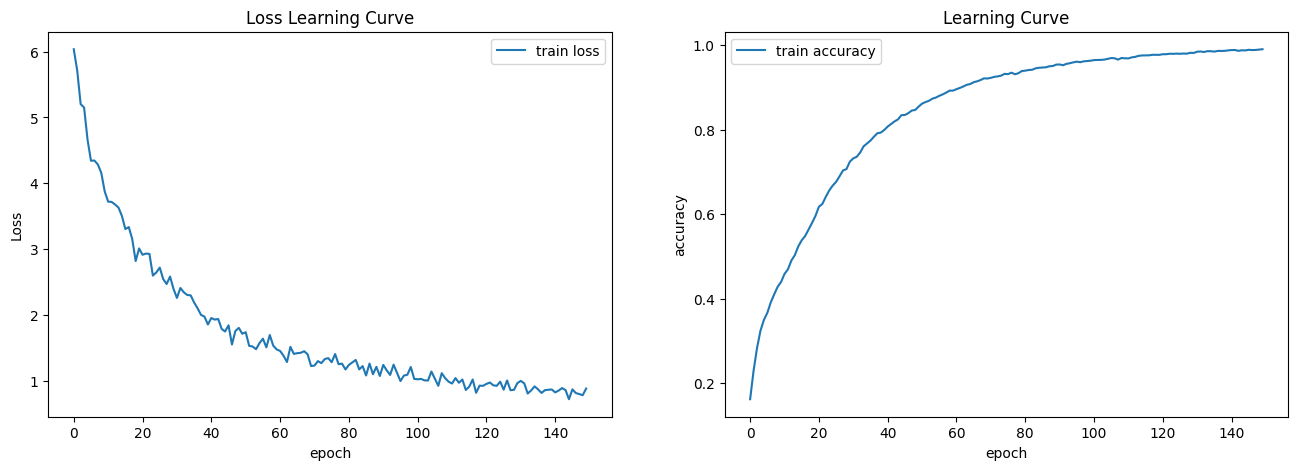

In [23]:
my_file = open(root + "all_losses4.txt", "r")

data = my_file.read()

losses_ = data.split("\n")
losses = [float(i) for i in losses_ if i != ""]

my_file = open(root + "all_accuracies_train4.txt", "r")

data = my_file.read()

train_accuracy_ = data.split("\n")
train_accuracy = [float(i) for i in train_accuracy_ if i != ""]
plot_lc(losses, train_accuracy)

## Generation
6. Реализуйте генерацию текста на основе жадного и случайного выбора очередного токена. Случайность должна быть не равновероятной, а основываться на предсказываемых вероятностях.


### LSTM

In [ ]:
df = pd.read_csv(root + "dataset_HP.csv")
target_unique_vals = df.target.value_counts().size
num_all_tokens_file = open(root + "tokens_len.txt", "r")
num_all_tokens = int(num_all_tokens_file.read())

In [ ]:
model = My_LSTM3(num_all_tokens, num_all_tokens, embedding_dim=embedding_dim, hidden_dim=hidden_dim)
model.load_state_dict(torch.load(root + "lstm_HP4.pt", map_location=torch.device('cpu')))
model.to(device)

My_LSTM3(
  (embedding): Embedding(8283, 8283)
  (lstm): LSTM(8283, 1000, batch_first=True)
  (lstm1): LSTM(1000, 200, batch_first=True)
  (lstm2): LSTM(200, 500, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=500, out_features=8283, bias=True)
)

In [ ]:
tokenizer = Tokenizer.from_file(root + 'saved_tokenizer.json')

In [ ]:
num_gen_sentences = 5
start_sentence = tokenizer.encode("He dashed back across the road, hurried up to his office, snapped at his secretary not to disturb him, seized his telephone, and had almost finished dialing his home number when he changed." +
                 "his mind. He put the receiver back down and stroked his mustache, thinking... no, he was being stupid. Potter wasn't such an unusual name. He was sure there were" +
                 "lots of people called Potter who had a son called Harry. Come to think of it, he wasn't even sure ")
st = np.array(start_sentence.ids)

greedy

In [ ]:
gen_sen = 0

for www in range(1, 1000):
    start = torch.tensor(st[np.newaxis, :])
    with torch.no_grad():
        output = model(start)
    topk_values, topk_indices = output.topk(3, dim=1)
    result_token = greedy_decoding(topk_indices).tolist()
    a_dropped = st[1:]
    st = np.append(a_dropped, result_token)
    if result_token[0] == 3:
        gen_sen += 1
        if gen_sen >= num_gen_sentences:
            break
        print()
        print()
        continue
    result_word = tokenizer.decode(result_token)
    print(result_word, end=' ')

the stone , and they had been a lot of books and was a lot of books and had been looking with the door . 

" i ' m not going to get past a hundred of magic ." 

" what ' s a few - wizard , and i ' ve got the house cup , but i ' ve got a stone cup of books ." 

" well , i ' m not going to get us ." 

" i ' m not going to get me to get up . 

probabilistic_sampling

In [ ]:
gen_sen = 0
for www in range(1, 1000):
    start = torch.tensor(st[np.newaxis, :])
    with torch.no_grad():
        output = model(start)
    topk_values, topk_indices = output.topk(3, dim=1)
    result_token = probabilistic_sampling(topk_values, topk_indices).tolist()
    a_dropped = st[1:]
    st = np.append(a_dropped, result_token)
    if result_token[0] == 3:
        gen_sen += 1
        if gen_sen >= num_gen_sentences:
            break
        print()
        print()
        continue
    result_word = tokenizer.decode(result_token)
    print(result_word, end=' ')

" you ' ve just been past me , but i ' m not good ." 

he had a eyes , and harry had been a lot of one of them had been enough . he ' d been to find me on the other room , and a large balls - oak . 

" i ' ve never got to be past your time to get past the house . 

harry had been been to try to be in trouble in a little - two of books and he had never been to a dark of one of the door and had been in his time to do that , and he had a very first - floor man of them , and they had been a bit on the door . 

" i ' m not going to get past the same ." 

## Markov chain

In [24]:
mc_model = Markov_Chain()
mc_model.fit(df)

probabilistic_sampling

In [ ]:
cur_token = 53
for www in range(1, 200):
    result_token = mc_model.generate_next_token(cur_token, greedy=False)
    result_word = tokenizer.decode([result_token])
    cur_token = result_token
    print(result_word, end=' ')
    if www % 15 == 0:
        print()

reckon dumbledore gently . it .  " the train to a large chocolate frog 
- know - haired family wizards .  " oh , the ground he looked 
as the other team ?"  " what you ?"  " oh , " 
i was still , i ' t see , the door open door , " 
it was a bit like a large doughnut in their mother ' ve got to 
a dragon , you ?"  harry ' t know ... i ' t want 
...  " but i suppose you ."  " i thought it -- you 
' s gone back into the other end of the other two cups , but 
what did the way ?" said hagrid , which was a lot at ron in 
his hand and then , he had a very long . he ' t been 
waiting for the mirror .  " i mean ..."  hermione . " i 
told hagrid , " you can ' s going to his head .  " 
and the door open with a few feet , and the house fifty ?"  
" i ' t 

greedy

In [ ]:
cur_token = 53
for www in range(1, 200):
    result_token = mc_model.generate_next_token(cur_token, greedy=True)
    result_word = tokenizer.decode([result_token])
    cur_token = result_token
    print(result_word, end=' ')
    if www % 15 == 0:
        print()

reckon he ' s a bit of the door .  " i ' s 
a bit of the door .  " i ' s a bit of the 
door .  " i ' s a bit of the door .  " 
i ' s a bit of the door .  " i ' s a 
bit of the door .  " i ' s a bit of the door 
.  " i ' s a bit of the door .  " i 
' s a bit of the door .  " i ' s a bit 
of the door .  " i ' s a bit of the door . 
 " i ' s a bit of the door .  " i ' 
s a bit of the door .  " i ' s a bit of 
the door .  " i ' s a bit of the door .  
" i ' s a bit of the door .  " i ' s 
a bit of the door .  " i ' s a bit of the 
door .  " 